<a href="https://colab.research.google.com/github/ikhwanperwira/confidence-vs-uncertainty/blob/main/REVISED_of_Explainable_AI_Confidence_and_Uncertainty_Based_on_Minimax_and_Relative_Uniformity_of_Softmax_Output.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Explainable AI: Confidence and Uncertainty Based on Minimax and Relative Uniformity of Softmax Output

By: Muhammad Ikhwan Perwira

In [ ]:
#@title Upgrade Keras
!pip install --upgrade keras

In [ ]:
#@title Load Data
from keras.api.datasets import mnist
import keras

(X_train, y_train), (X_test, y_test) = keras.datasets.mnist.load_data()

print("X_train shape:", X_train.shape)
print("y_train shape:", y_train.shape)
print(X_train.shape[0], "train samples")
print(X_test.shape[0], "test samples")

X_train shape: (60000, 28, 28)
y_train shape: (60000,)
60000 train samples
10000 test samples


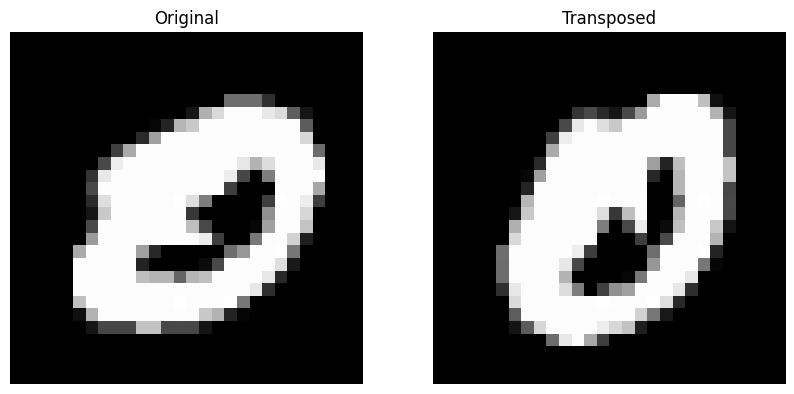

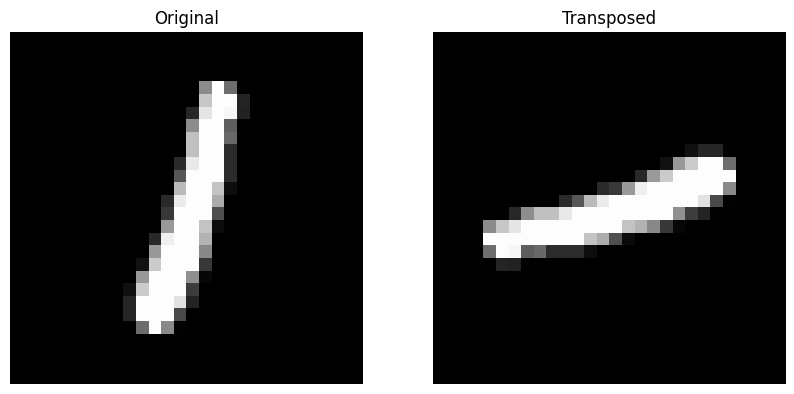

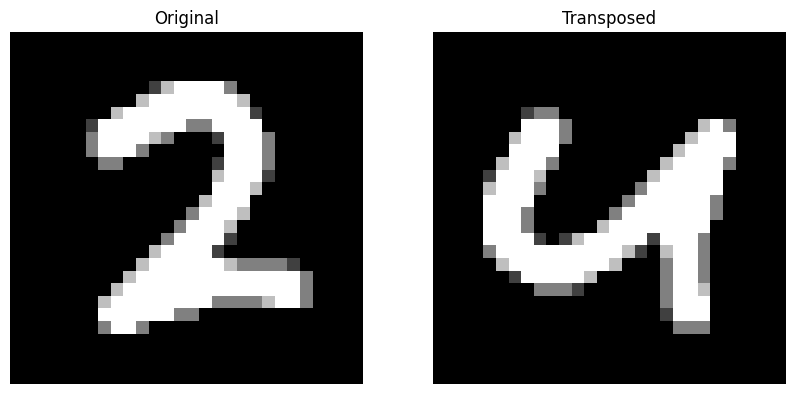

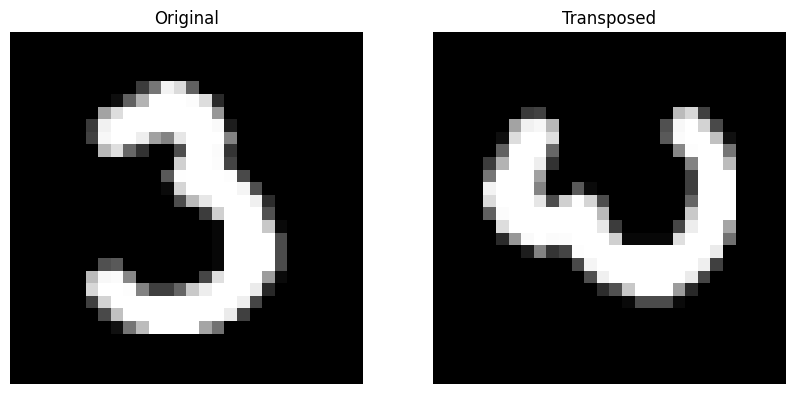

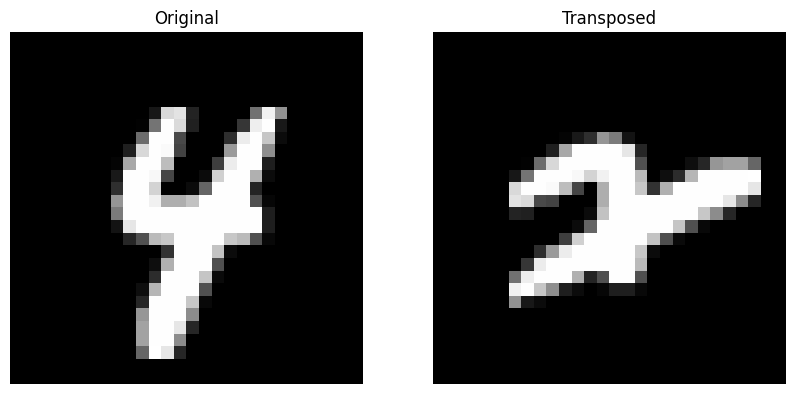

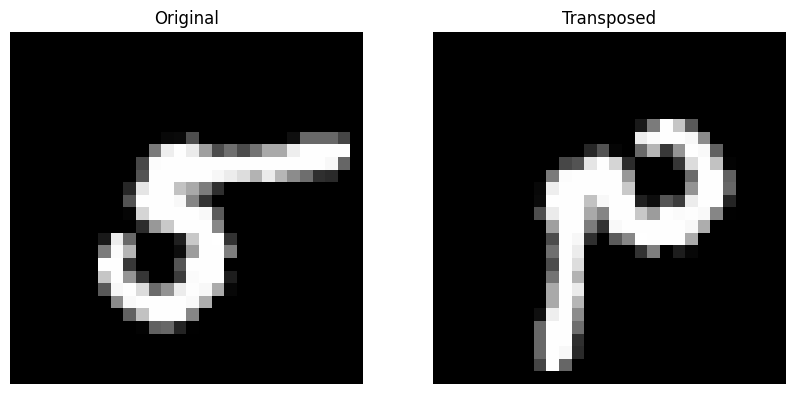

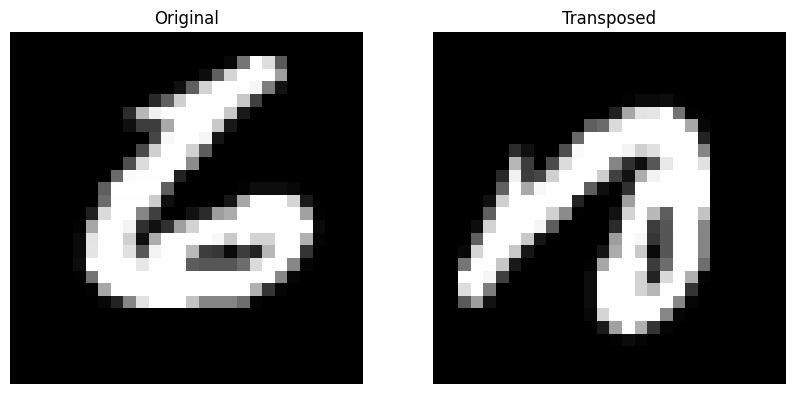

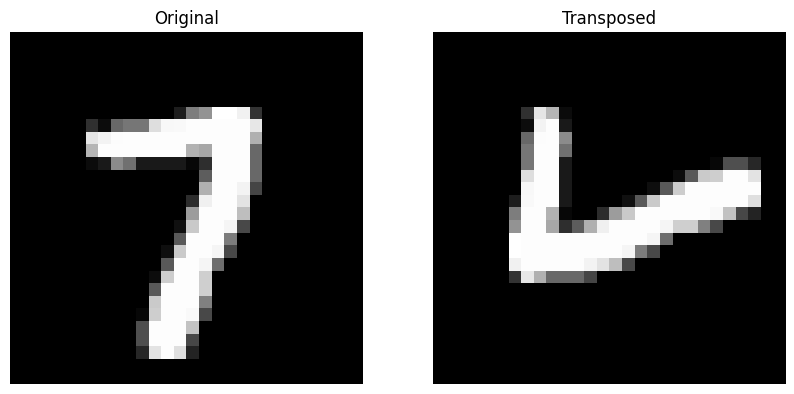

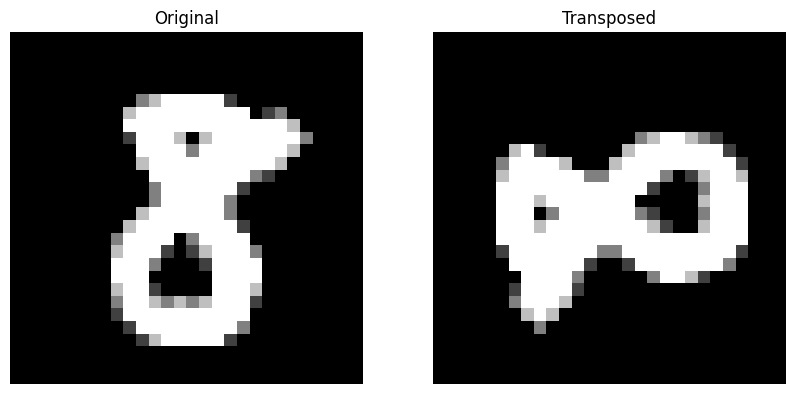

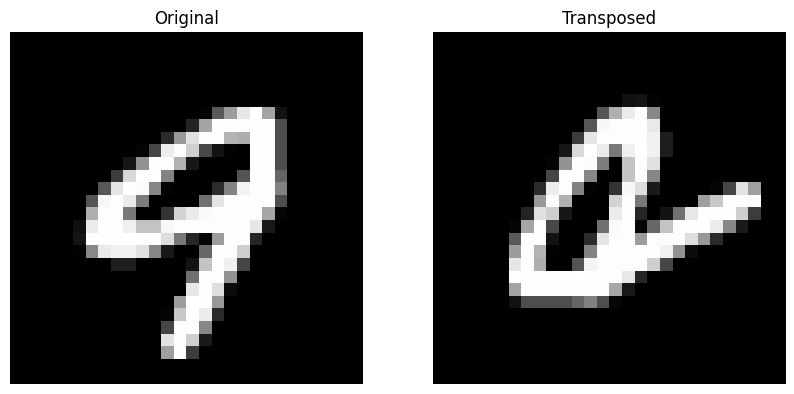

In [ ]:
#@title Transposed Image
import numpy as np
import matplotlib.pyplot as plt

testing_array = []

for selector in range(10):
    # Select images for a specific class
    y_select = y_test == selector
    y_test_o = y_test[y_select][0]
    X_test_o = X_test[y_select]
    X_test_t = np.transpose(X_test_o, (0, 2, 1))

    testing_array.append(
        (
            y_test_o,
            X_test_o,
            X_test_t
        )
    )

    # Plot the first image (original and transposed)
    plt.figure(figsize=(10, 5))

    # Display the original image
    plt.subplot(1, 2, 1)
    plt.title('Original')
    plt.imshow(X_test_o[-1], cmap='gray')
    plt.axis('off')

    # Display the transposed image
    plt.subplot(1, 2, 2)
    plt.title('Transposed')
    plt.imshow(X_test_t[-1], cmap='gray')
    plt.axis('off')

    plt.show()


In [ ]:
#@title Define Func

def get_confidence_and_uncertainty_vanilla(pred):
  """
  Input Shape: (n_samples, n_classes)
  Output Shape: (n_samples, 2)
  """

  dtype = np.float32
  pred = pred.astype(dtype)

  N = float(pred.shape[-1])
  a = np.max(pred, axis=-1).astype(dtype)
  b = np.min(pred, axis=-1).astype(dtype)


  with np.errstate(divide='ignore', invalid='ignore'):
    c = ((a*N)-1)/(N-1)
    relative_uniform = (1-a)/(N-1)
    u = b/relative_uniform

  c =  c.astype(dtype)
  u =  u.astype(dtype)

  return c, u

def get_confidence_and_uncertainty_revised(pred):
  """
  Input Shape: (n_samples, n_classes)
  Output Shape: (n_samples, 2)
  """

  dtype = pred.dtype
  with np.errstate(divide='ignore', invalid='ignore'):
    # pred_logits = np.log2(pred/(1-pred))
    pred_logits = pred
    inf = -np.log2(np.finfo(dtype).eps)

    N = float(pred_logits.shape[-1])
    a = np.max(pred_logits, axis=-1).astype(dtype)
    b = np.min(pred_logits, axis=-1).astype(dtype)

    c = np.log2(N-1) - np.log2(N) - np.log2(1-a)
    u = -np.log2(N) - np.log2(b) - c

    c =  c.astype(np.float128)
    u =  u.astype(np.float128)

    c /= inf # normalized from [0, inf_relative] to [0,1]
    u /= inf # normalized from [0, inf] to [0, inf_relative]
    u = ((2**u)-1)/((2**u)+1) # normalized from [0, inf_relative] to [0,1]

  return c, u

In [ ]:
import numpy as np

def preprocess_testing_array(testing_array):
    """
    This function preprocesses the global testing_array to create a single batch
    of combined data with a mask for original and transposed inputs.
    """
    # Create an empty list to store combined data
    combined_data = []
    for arr in testing_array:
        label = arr[0]
        X_original = arr[1]
        X_transposed = arr[2]

        # Create the mask to differentiate between original and transposed
        original_mask = np.zeros(X_original.shape[0], dtype=bool)
        transposed_mask = np.ones(X_transposed.shape[0], dtype=bool)

        # Concatenate the data, ensuring each entry has a mask for original vs transposed
        X_combined = np.concatenate([X_original, X_transposed], axis=0)
        mask_combined = np.concatenate([original_mask, transposed_mask], axis=0)
        labels_combined = np.repeat(label, X_combined.shape[0])

        combined_data.append((labels_combined, X_combined, mask_combined))

    return combined_data

combined_data = preprocess_testing_array(testing_array)

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

def save_fig_revised(epoch):
    once = False

    # Iterate over each label in the new_combined_testing_array
    for labels, X_combined, mask_combined in combined_data:
        # Perform the prediction in one go for both original and transposed data
        y_pred_combined = model.predict(X_combined)

        # Get argmax for both original and transposed
        y_pred_combined_argmax = np.argmax(y_pred_combined, axis=1)

        # Masks for original and transposed
        mask_original = mask_combined == 0
        mask_transposed = mask_combined == 1

        # Is correct for both original and transposed
        is_correct_original = (y_pred_combined_argmax[mask_original] == labels[mask_original])
        is_correct_transposed = (y_pred_combined_argmax[mask_transposed] == labels[mask_transposed])

        # Get confidence and uncertainty for both original and transposed
        conf_combined, uncert_combined = get_confidence_and_uncertainty_revised(y_pred_combined)

        # Separate the confidence and uncertainty for original and transposed
        conf_original = conf_combined[mask_original]
        uncert_original = uncert_combined[mask_original]
        conf_transposed = conf_combined[mask_transposed]
        uncert_transposed = uncert_combined[mask_transposed]

        # Create a figure and axis
        fig, ax = plt.subplots()

        # Draw the x and y axis lines
        ax.axhline(0, color='black', linewidth=0.5)
        ax.axvline(0, color='black', linewidth=0.5)

        # Draw grid lines
        ax.grid(which='both')

        # Plot the points
        marker_size_original = 4 + 3 * (1 - uncert_original)
        marker_size_transposed = 4 + 3 * (1 - uncert_transposed)

        color_original_true = 'darkgreen'
        color_original_false = 'darkorange'
        color_transposed_true = 'blue'
        color_transposed_false = 'red'

        # Use a mask to decide the colors and markers
        ax.scatter(conf_original[is_correct_original], uncert_original[is_correct_original],
                   c=color_original_true, s=marker_size_original[is_correct_original],
                   alpha=0.25, label="Original True", marker='o')
        ax.scatter(conf_original[~is_correct_original], uncert_original[~is_correct_original],
                   c=color_original_false, s=marker_size_original[~is_correct_original],
                   alpha=0.25, label="Original False", marker='o')

        ax.scatter(conf_transposed[is_correct_transposed], uncert_transposed[is_correct_transposed],
                   c=color_transposed_true, s=marker_size_transposed[is_correct_transposed],
                   alpha=0.25, label="Transposed True", marker='o')
        ax.scatter(conf_transposed[~is_correct_transposed], uncert_transposed[~is_correct_transposed],
                   c=color_transposed_false, s=marker_size_transposed[~is_correct_transposed],
                   alpha=0.25, label="Transposed False", marker='o')

        once = True  # To avoid repeating the legend

        # Add labels and arrows
        ax.set_xlabel('Confidence')
        ax.set_ylabel('Uncertainty')

        ax.axhline(y=0.5, color='black', linestyle='--')
        ax.axvline(x=0.5, color='black', linestyle='--')

        # Fix the view size to 0,0 until 1,1
        ax.set_xlim(-.1, 1.1)
        ax.set_ylim(-.1, 1.1)

        # Set the title
        plt.title(f"Label {labels[0]} | Epoch {epoch}")

        # Fix the legend to the upper right and not inside of a graphic
        plt.legend(loc='upper right', bbox_to_anchor=(1, 1.1))

        # Name the quadrants
        ax.text(0.75, 0.75, 'Need\nValidation', fontsize=15, ha='center', va='center', color='darkorange', alpha=1)
        ax.text(0.25, 0.75, "Unsure", fontsize=15, ha='center', va='center', color='gray', alpha=1)
        ax.text(0.25, 0.25, "Don't\nTrust!", fontsize=15, ha='center', va='center', color='red', alpha=0.8)
        ax.text(0.75, 0.25, "Please\nTrust!", fontsize=15, ha='center', va='center', color='green', alpha=0.8)

        # Save fig
        plt.savefig(f"label_{labels[0]}_epoch_{epoch}.png")

        # Close the plot
        plt.close()


In [ ]:
# prompt: custom model checkpoint for every epoch on start draw matplotlib

import keras
import numpy as np
import matplotlib.pyplot as plt

# Custom callback to save model checkpoints and draw matplotlib plots
class CustomCallback(keras.callbacks.Callback):
    def on_epoch_begin(self, epoch, logs=None):
        save_fig_revised(epoch)


cb = [
    CustomCallback()
]



In [ ]:
!rm -rf ./*

In [ ]:
# Define the CNN model
model = keras.models.Sequential([
  keras.layers.Input(shape=(28,28,1)),
  keras.layers.Rescaling(1./255),
  keras.layers.Conv2D(32, (3, 3), activation='relu'),
  keras.layers.MaxPooling2D((2, 2)),
  keras.layers.Conv2D(64, (3, 3), activation='relu'),
  keras.layers.MaxPooling2D((2, 2)),
  keras.layers.Flatten(),
  keras.layers.Dropout(0.5), #IMPORTANT
  keras.layers.Dense(10, activation='softmax', kernel_initializer='glorot_normal') # Output layer with 10 units and softmax activation
])

# Compile the model
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

# Train the model
model.fit(X_train, y_train, epochs=10, callbacks=cb) # Adjust epochs as needed

# Evaluate the model
loss, accuracy = model.evaluate(X_test, y_test)
print(f"Test Loss: {loss}")
print(f"Test Accuracy: {accuracy}")

62/62 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step
71/71 ━━━━━━━━━━━━━━━━━━━━ 2s 26ms/step
65/65 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step
62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step
56/56 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step
60/60 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step
65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step
Epoch 1/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 9s 3ms/step - accuracy: 0.8637 - loss: 0.4353
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
71/71 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
Epoch 2/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - accuracy: 0.9737 - loss: 0.0837
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step

In [ ]:
model.fit(X_train, y_train, epochs=50, batch_size=32, callbacks=cb, initial_epoch=10) # Adjust epochs as needed

62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
71/71 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
Epoch 11/50
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - accuracy: 0.9890 - loss: 0.0325
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
71/71 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Epoch 12/50
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 16s 3ms/step - accuracy: 0.9899 - loss: 0.0294
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
71

In [ ]:
from PIL import Image
import glob
for selector in range(10):
  # Step 1: Collect all image files in order
  # Adjust the pattern to match your filenames and ensure they're sorted numerically
  file_pattern = f"label_{selector}_epoch_*.png"
  files = sorted(glob.glob(file_pattern), key=lambda x: int(x.split('_')[-1].split('.')[0]))

  # Step 2: Open images
  frames = [Image.open(file) for file in files]

  # Step 3: Create forward-backward sequence
  # Add reversed frames (excluding the last frame to avoid duplication)
  forward_backward_frames = frames + frames[-2::-1]

  # Step 4: Save as GIF
  output_file = f"label_{selector}.gif"
  forward_backward_frames[0].save(output_file, format='GIF', save_all=True,
                                  append_images=forward_backward_frames[1:], duration=100, loop=0)

  print(f"GIF saved as {output_file}")

GIF saved as label_0.gif
GIF saved as label_1.gif
GIF saved as label_2.gif
GIF saved as label_3.gif
GIF saved as label_4.gif
GIF saved as label_5.gif
GIF saved as label_6.gif
GIF saved as label_7.gif
GIF saved as label_8.gif
GIF saved as label_9.gif


In [ ]:
from PIL import Image
import glob

# Define the grid dimensions
grid_width = 3
grid_height = 3

# List to store frames for the final GIF
all_frames = []

# Loop over labels 0 to 8 (as per your request to skip label 9 for simplicity)
for selector in range(9):
    # Step 1: Collect all image files in order
    file_pattern = f"label_{selector}_epoch_*.png"
    files = sorted(glob.glob(file_pattern), key=lambda x: int(x.split('_')[-1].split('.')[0]))

    # Step 2: Open images
    frames = [Image.open(file) for file in files]

    # Step 3: Create forward-backward sequence
    forward_backward_frames = frames + frames[-2::-1]

    # Step 4: Add the sequence to the all_frames list
    all_frames.append(forward_backward_frames)

# Now, create the GIF with all frames from each label in a 3x3 grid
output_frames = []

# Create the final grid of frames
for frame_idx in range(len(all_frames[0])):  # Iterate over each frame of the forward-backward sequence
    # Create a new blank image for the grid
    width, height = all_frames[0][frame_idx].size
    grid_image = Image.new('RGB', (width * grid_width, height * grid_height))

    # Fill the grid with the current frame for each label
    for idx in range(9):  # 9 labels
        row = idx // grid_width
        col = idx % grid_width
        grid_image.paste(all_frames[idx][frame_idx], (col * width, row * height))

    # Append the grid image to the list of frames for the GIF
    output_frames.append(grid_image)

# Step 5: Save as GIF
output_file = "combined_labels.gif"
output_frames[0].save(output_file, format='GIF', save_all=True, append_images=output_frames[1:], duration=100, loop=0)

print(f"GIF saved as {output_file}")


GIF saved as combined_labels.gif
